Zipporah Mutua-KPSK-deKUT-02-34
Maize Pest and Disease Invasion 

Goal: Predict maize pest invasion levels based on weather data.
Method: Train machine learning models using simulated weather and pest severity data.

Inputs: Max/min temperature, rainfall, humidity, wind speed.
Outputs: Risk levels (Low, Moderate, High) for:
Fall Armyworm
Maize Ear Rot
Maize Stem Borer

Use Case: Early warning for farmers and agronomists to make informed pest control decisions.

Tech Stack: Python, Scikit-learn, Streamlit (for web interface).

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import librosa.display
import joblib
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("maize_pest_data_.csv")
df.head()


,temp_max,temp_min,rainfall,humidity,wind_speed,soil_moisture,ndvi,altitude,fall_armyworm,ear_rot,stem_borer,corn_earworm,locust
0,32.5,24.3,2.5,72.1,3.3,50.3,0.55,1208.9,Medium,Low,NaN,High,Medium
1,39.4,23.6,3.2,86.6,3.0,10.8,0.72,1265.8,NaN,NaN,NaN,NaN,Low
2,36.8,21.7,9.6,51.3,1.8,19.3,0.59,2365.3,Low,NaN,Medium,High,High
3,35.2,25.6,2.1,51.5,5.1,42.7,0.26,930.5,Medium,High,High,Low,NaN
4,29.9,18.0,10.2,72.8,4.1,28.8,0.33,1836.3,Low,Low,Medium,NaN,Medium


In [7]:
# Initial Inspection
print(df.info())
print(df.isna().sum())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_max       2500 non-null   float64
 1   temp_min       2500 non-null   float64
 2   rainfall       2500 non-null   float64
 3   humidity       2500 non-null   float64
 4   wind_speed     2500 non-null   float64
 5   soil_moisture  2500 non-null   float64
 6   ndvi           2500 non-null   float64
 7   altitude       2500 non-null   float64
 8   fall_armyworm  1901 non-null   object 
 9   ear_rot        1894 non-null   object 
 10  stem_borer     1881 non-null   object 
 11  corn_earworm   1859 non-null   object 
 12  locust         1858 non-null   object 
dtypes: float64(8), object(5)
memory usage: 254.0+ KB
None
temp_max           0
temp_min           0
rainfall           0
humidity           0
wind_speed         0
soil_moisture      0
ndvi               0
altitude           0
fall_a

In [8]:
# List of pest columns with categorical severity
pest_cols = ['fall_armyworm', 'ear_rot', 'stem_borer', 'corn_earworm', 'locust']

# Define ordinal encoding for severity
severity_map = {
    'None': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3
}

# Convert all pest severity levels to ordinal numbers
for col in pest_cols:
    df[col] = df[col].map(severity_map).fillna(0).astype(int)


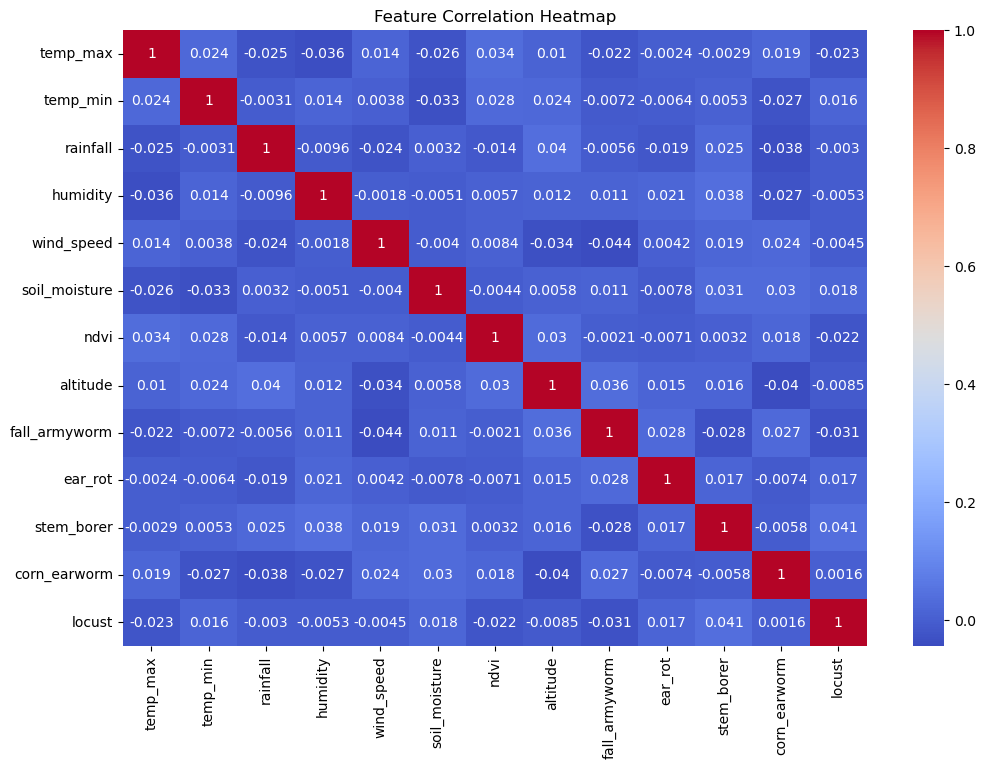

In [9]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

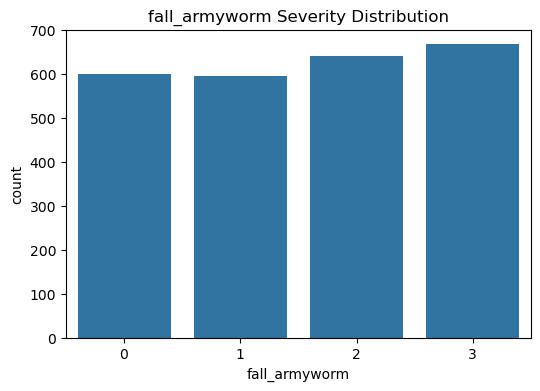

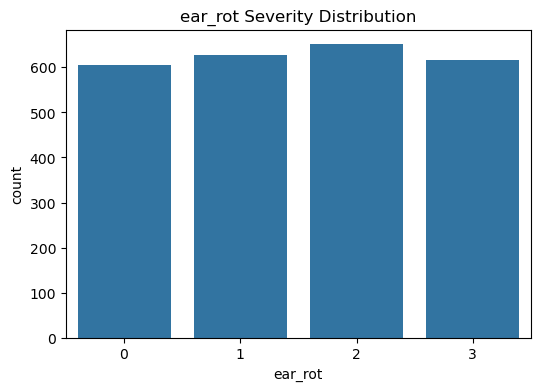

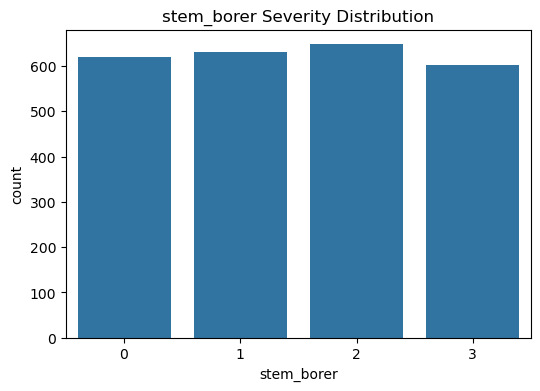

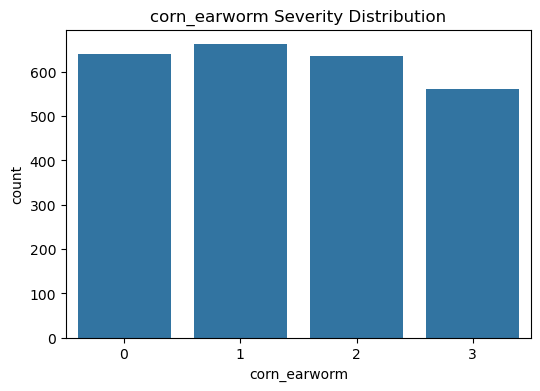

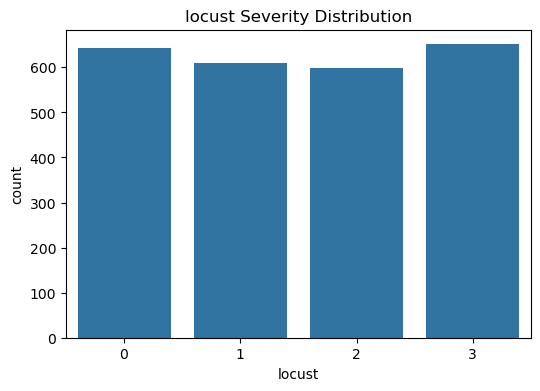

In [10]:
# Pest severity counts
for col in pest_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col)
    plt.title(f"{col} Severity Distribution")
    plt.show()

In [11]:
# Create new feature: temperature range
df['temp_range'] = df['temp_max'] - df['temp_min']


In [14]:
from sklearn.model_selection import train_test_split

# Features and targets
X = df[['temp_max', 'temp_min', 'rainfall', 'humidity', 'wind_speed',
        'soil_moisture', 'ndvi', 'altitude']]
Y = df[pest_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [16]:
# Initialize and train model
model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


In [21]:
models = {}
for pest in pest_cols:
    clf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
    clf.fit(X_train, y_train[pest])
    models[pest] = clf


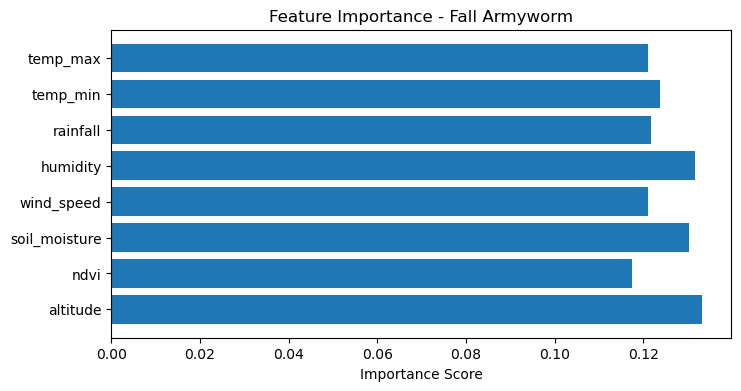

In [22]:
importances = model.estimators_[0].feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Importance Score")
plt.title("Feature Importance - Fall Armyworm")
plt.gca().invert_yaxis()
plt.show()


In [24]:
sample = pd.DataFrame([{
    "temp_max": 34.0,
    "temp_min": 22.0,
    "rainfall": 5.0,
    "humidity": 70.0,
    "wind_speed": 3.2,
    "soil_moisture": 35.0,
    "ndvi": 0.65,
    "altitude": 1500
}])

severity_map_reverse = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High'}
predictions = {pest: severity_map_reverse[models[pest].predict(sample)[0]] for pest in pest_cols}

print("📊 Predicted Pest Severities:")
for pest, level in predictions.items():
    print(f"{pest}: {level}")


📊 Predicted Pest Severities:
fall_armyworm: Medium
ear_rot: None
stem_borer: Low
corn_earworm: Low
locust: High


In [25]:
import joblib
import os

# Create a directory to save models
os.makedirs("saved_models", exist_ok=True)

# Save each trained pest model separately
for pest in pest_cols:
    joblib.dump(models[pest], f"saved_models/{pest}_model.pkl")

print("✅ All pest models saved successfully.")


✅ All pest models saved successfully.
